Goal: create maps of street networks, but only within a buffer around a geocoded place.

Next goal: functions to measure and visualize urban indicators.

Steps:
- write code to plot heatmap of point density [DONE]
- convert heatmap code to function [DONE]
- write code to clip heatmap to buffer ring [DONE]
- write code to get osm POI data based on category
- allow get_buffer() fxn to take coord tuple param
- put plotting of text as separate fxn (and reflect map content)

Ideas for Urban Indicators:
- intersection density (hexbin/heatmap) [DONE]
- density of x-height buildings (hexbin/heatmap)
- density of x kind of amenity (hexbin/heatmap)
    - sustenance (restaurants, bars, etc.)
    - education (school, college, university, etc.)
    - healthcare (clinic, hospital, etc.)
    - public service (fire station, town hall, police, etc.)
- density of shops [DONE]
- isochrone from geocoded point
- betweenness centrality of street intersections [DONE]

Step 1: Import packages

In [22]:
import osmnx as ox
import geopandas as gpd
import contextily as cx
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import networkx as nx

Step 2: Generate buffer around location of interest

In [23]:
# Set name for Nominatim query
query = "Metro Manila"
buffer_dist = 5_000

# Get buffer with aforementioned parameters using custom function
from urban_indicators_scripts import get_buffer_from_place

buffer = get_buffer_from_place(query, buffer_dist)

c:\Users\Kurt\miniconda3\envs\geopython\Lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


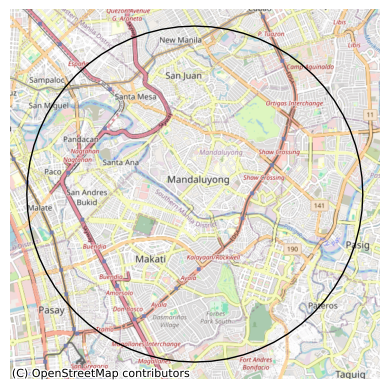

In [24]:
# Check if buffer location is correct
ax = buffer.to_crs("EPSG:3857").plot(
    facecolor="none"
)
cx.add_basemap(ax=ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

Step 3: Extract street network within buffer then pre-process

In [25]:
# Get road network within buffer
graph = ox.graph_from_polygon(
    buffer.geometry[0],
    network_type="all_private",
    retain_all=True,
    simplify=True
)

# Convert intersections and streets to geodataframe
intersections, streets = ox.graph_to_gdfs(graph)

In [26]:
# Reproject both GDFs to pseudo-mercator
streets = streets.to_crs("EPSG:3857")
intersections = intersections.to_crs("EPSG:3857")

In [27]:
# Parse `lanes` column in streets GDF using custom function
from urban_indicators_scripts import parse_street_lanes

streets = parse_street_lanes(streets)
streets.lanes.unique()

array([2, 5, 4, 1, 3, 6])

In [28]:
streets.head()

osmid  lanes               name      highway  \
u        v           key                                                     
12067355 6225038926  0    760239290      2  C. Jose Extension  residential   
         750630860   0    238967422      5               EDSA        trunk   
12067542 11555850995 0      4483562      2     Gilmore Avenue    secondary   
         5427021057  0    563077077      2         5th Street  residential   
         1637315661  0    563077077      2         5th Street  residential   

                         maxspeed  oneway reversed   length  ref  \
u        v           key                                           
12067355 6225038926  0         30   False     True   12.005  NaN   
         750630860   0         60    True    False  152.245    1   
12067542 11555850995 0         50    True    False   44.166  NaN   
         5427021057  0        NaN   False    False   65.402  NaN   
         1637315661  0        NaN   False     True  278.885  NaN   

                                                                   geometry  \
u        v           key                                                      
12067355 6225038926  0    LINESTRING (13470863.453 1636114.288, 13470865...   
         750630860   0    LINESTRING (13470863.453 1636114.288, 13470837...   
12067542 11555850995 0    LINESTRING (13473354.260 1645009.493, 13473377...   
         5427021057  0    LINESTRING (13473354.260 1645009.493, 13473412...   
         1637315661  0    LINESTRING (13473354.260 1645009.493, 13473349...   

                         tunnel access service width bridge junction  
u        v           key                                              
12067355 6225038926  0      NaN    NaN     NaN   NaN    NaN      NaN  
         750630860   0      NaN    NaN     NaN   NaN    NaN      NaN  
12067542 11555850995 0      NaN    NaN     NaN   NaN    NaN      NaN  
         5427021057  0      NaN    NaN     NaN   NaN    NaN      NaN  
         1637315661  0      NaN    NaN     NaN   NaN    NaN      NaN

Step 4: Plotting the street network and intersection heatmap

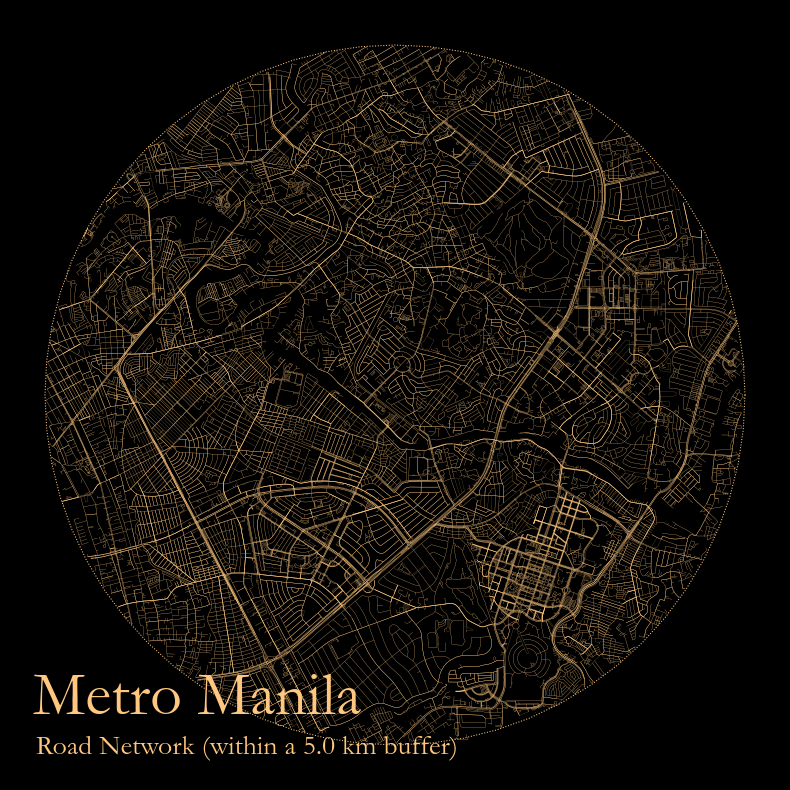

In [29]:
# Plot street network
from urban_indicators_scripts import plot_streets, plot_heatmap

fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    width_factor=0.1,
    color_scheme="copper"
)

# plot_heatmap(
#     intersections,
#     "street_count",
#     bins=500,
#     ax=ax,
#     alpha=0.7,
#     color_scheme="BuPu_r",
#     bounds=ring_bounds
# )

Part B: Generating a heatmap for other POIs

Step 1: Extract POIs within buffer

In [39]:
# Extract all shops within the buffer
pois = ox.features_from_polygon(
    buffer.geometry[0],
    {
        # "shop": True,
        # "amenity": ["fast_food", "restaurant", "cafe"]
        "building:levels": [str(i) for i in range(20,100)],
    }
)

# Examine number of rows and columns
pois.shape

(875, 85)

Step 2: Clean up POI data

In [40]:
# Import drop_nan_cols function we created
from urban_indicators_scripts import drop_nan_cols, filter_elem_type

# Apply imported function
# Parameters: gdf, max % of rows that are NaNs
pois = drop_nan_cols(pois, 0.75)

In [41]:
# Examine # of rows & cols after pre-processing
pois.shape

(875, 8)

In [42]:
# Flatten column indices
# (this should be in the function)
pois = pois.reset_index()

pois.head()

,element_type,osmid,geometry,addr:city,name,nodes,building,building:levels,height,building:part
0,way,22788808,"POLYGON ((121.02140 14.55751, 121.02152 14.557...",Makati,Philamlife Tower,"[244891956, 244891957, 244891958, 244891959, 2...",commercial,48,200,NaN
1,way,24547892,"POLYGON ((121.03491 14.56385, 121.03491 14.563...",NaN,Hidalgo Place,"[266904913, 5209772931, 5209772930, 266904914,...",residential,24,87.6,NaN
2,way,24547895,"POLYGON ((121.03508 14.56457, 121.03504 14.564...",NaN,Rizal Tower,"[266905127, 2312911335, 2312911334, 2312911330...",apartments,47,161,NaN
3,way,24547947,"POLYGON ((121.03508 14.56529, 121.03488 14.565...",NaN,Luna Gardens,"[266905163, 266905164, 266905165, 266905166, 2...",apartments,39,134.9,NaN
4,way,24547950,"POLYGON ((121.03551 14.56572, 121.03551 14.565...",NaN,Amorsolo East,"[266905215, 266905216, 266905217, 266905218, 2...",residential,30,107,NaN


In [43]:
# Assign weight to all POIs (for heatmap)
pois["weight"] = 1.0

In [44]:
# Reproject to Pseudo-Mercator
pois = pois.to_crs("EPSG:3857")

In [45]:
# Set feature geometries as their centroids
# (this should be in the function)
pois["geometry"] = pois["geometry"].centroid
pois.shape

(875, 11)

In [46]:
pois["building:levels"] = pois["building:levels"].apply(
    lambda x: max(x) if isinstance(x, list) == True else x
)

pois["building:levels"] = pois["building:levels"].astype(int)

Step 3: Plot POI density heatmap

d:\WORK\ONLINE COURSES\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:384: RuntimeWarning: divide by zero encountered in log2
  logheatmap = np.log2(heatmap)
d:\WORK\ONLINE COURSES\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:388: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  logheatmap = ndimage.filters.gaussian_filter(


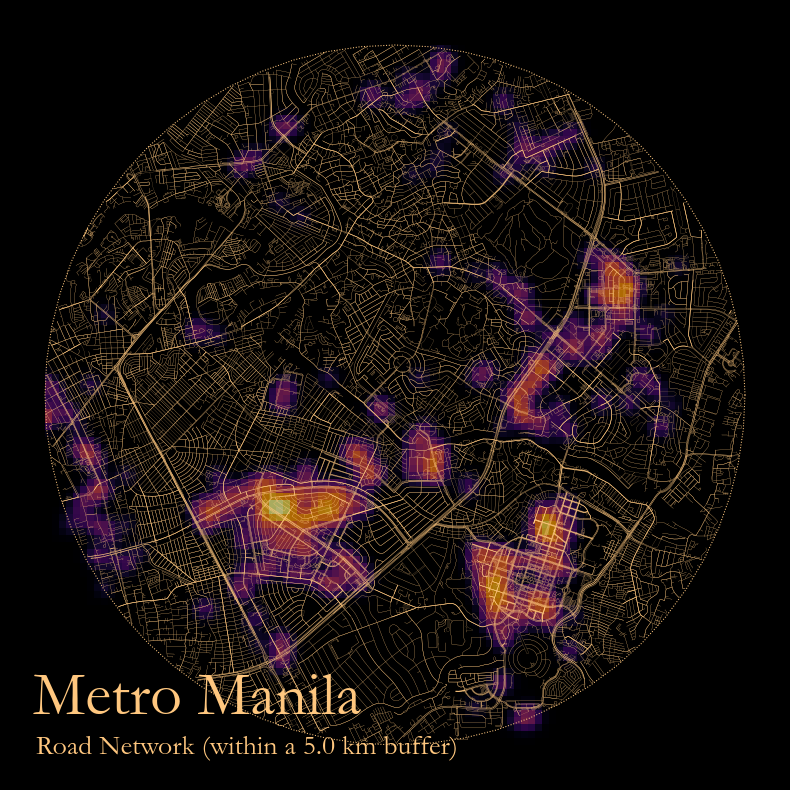

In [47]:
fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    width_factor=0.1,
    color_scheme="copper"
)

plot_heatmap(
    pois,
    "building:levels",
    bins=100,
    ax=ax,
    alpha=0.7,
    color_scheme="inferno",
    bounds=ring_bounds
)

Part C: Visualizing betweenness centrality of street intersections

Step 1: Calculate betweenness centrality per node

In [17]:
len(intersections)

47870

In [18]:
# Can't run for very big networks, even with k ~= 1% of total no. of nodes
bc = nx.betweenness_centrality(graph, weight="street_count", k=1_000)

KeyboardInterrupt: 

Step 2: Join betweenness values to each node via osmid

In [ ]:
nx.set_node_attributes(graph, bc, "bc")

Step 3: Convert graph to GDFS, then preprocess

In [ ]:
intersections, streets = ox.graph_to_gdfs(graph)

In [ ]:
streets = streets.to_crs("EPSG:3857")
intersections = intersections.to_crs("EPSG:3857")

In [ ]:
# Parse `lanes` column in streets GDF using custom function
from urban_indicators_scripts import parse_street_lanes

streets = parse_street_lanes(streets)
streets.lanes.unique()

In [ ]:
# Multiply by 1,000 (since function calculates log of heatmap)
intersections["bc_1k"] = intersections["bc"] * 1_000

Step 4: Plot betweenness centrality!

In [ ]:
# Plot street network
from urban_indicators_scripts import plot_streets, plot_heatmap

fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    color_scheme="copper"
)

# Plot heatmap of betweenness centrality
plot_heatmap(
    intersections,
    "bc_1k",
    ax=ax,
    alpha=0.9,
    color_scheme="inferno",
    bounds=ring_bounds
)